In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost_order import process_kline, inference
from helper import get_binance_ohlc_time, generate_date_list, calculate_rsi_with_ema, is_decrease, is_pin_bar, generate_df_klines
import random
TRAINING = False
INFERENCE_XG = False

/home/orin/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []

    index_condition = []
    pick_index = []

    if model is None:
        index_condition = random.sample(range(100, len(df)), num_random)
        index_condition.sort()
        for i in index_condition:
            if df.iloc[i-1]['close'] < df.iloc[i-1]['open'] and df.iloc[i-2]['Trend'] == 1 and df.iloc[i-3]['Trend'] == 1:
                for j in range (i, i+3):
                    if df.iloc[j]['high'] > df.iloc[i-1]['open']:
                        pick_index.append((j, df.iloc[i-1]['open']))
                        break
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.loc[i-seq:i-1, ["open", "high", "low", "close", "volumn"]].to_numpy()
            x_array_cp = x_array.copy()
            rsi_6 = calculate_rsi_with_ema(x_array, 6)
            y_pred_prob = inference(x_array, model)
            if y_pred_prob == 1:
                if manual_cond:
                    # if is_decrease(x_array_cp[-1]) or is_decrease(x_array_cp[-2]) or is_pin_bar(x_array_cp[-1]): 
                    if rsi_6[-1] > 20 and rsi_6[-2] > 20:
                        index_condition.append(i)
                else:
                    index_condition.append(i)
        index_condition = sorted(index_condition)
    # print([i[0] for i in pick_index])
    for (i,open_price_i) in pick_index:
        
        # open_price_i = df['open'].iloc[i]
        high_check = False
        low_check = False
        open_time = df.iloc[i]['timestamp']
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            low_sma = df['low'].iloc[j] < df['lower'].iloc[j] * 1.002
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * open_price_i
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * open_price_i
            if low_sma:
                print(open_time, "low sma")
                pnl = money * (1 - df['lower'].iloc[j] * 1.002 / open_price_i)
                balance += pnl
                list_reward.append(balance)
                results.append((i, open_time,j,open_price_i, "sma", round(pnl,2)))
                number_low+=1
                low_check = True
                break
            if (high_check and low_check) or (high_check and low_sma):
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, open_time,j, df.iloc[j]['timestamp'],open_price_i, "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, open_time,j, df.iloc[j]['timestamp'], open_price_i, "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < open_price_i:
                pnl = money * (1 - df.iloc[j]['close'] / open_price_i)
                balance += pnl
            else:
                pnl = -money * (df.iloc[j]['close'] / open_price_i-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, open_time,j, "not",open_price_i, df.iloc[j]['close'], round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, pick_index, number_high, number_low, list_reward, prices_list

# Inference


In [3]:
if INFERENCE_XG:
    bst = xgb.Booster()
    bst.load_model('./weights/ORDIUSDT_15m_tp3_sl3_60pcent_mancond_fapiv1.json')


In [4]:
threshold = 0.01

def classify_trend(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] > row['SMA'] * (1 + threshold):
        return 2
    elif row['close'] < row['SMA'] * (1 - threshold):
        return 1
    else:
        return 0
    
def classify_trend_through(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] < row['SMA'] * (1 - threshold) and row['open'] > row['SMA']:
        return 1
    else:
        return 0
    
def classify_trend_bollband(row):
    if pd.isna(row['upper']):
        return None  # Không đủ dữ liệu để phân loại
    elif (row['low'] + row['high'])/2 > row['upper']:
        return 1
    elif (row['low'] + row['high'])/2 < row['lower']:
        return 2
    else:
        return 0



In [13]:
df_all, csv_link = generate_df_klines(start = "2023-07-16", end = "2025-03-20", symb = "XRPUSDT", interval = "4h")

2023-07-16 03:15:00 -> 2023-09-18 03:00:00
https://api.mexc.com/api/v3/klines
2023-09-18 03:15:00 -> 2023-11-21 03:00:00
https://api.mexc.com/api/v3/klines
2023-11-21 03:15:00 -> 2024-01-24 03:00:00
https://api.mexc.com/api/v3/klines
2024-01-24 03:15:00 -> 2024-03-28 03:00:00
https://api.mexc.com/api/v3/klines
2024-03-28 03:15:00 -> 2024-05-31 03:00:00
https://api.mexc.com/api/v3/klines
2024-05-31 03:15:00 -> 2024-08-03 03:00:00
https://api.mexc.com/api/v3/klines
2024-08-03 03:15:00 -> 2024-10-06 03:00:00
https://api.mexc.com/api/v3/klines
2024-10-06 03:15:00 -> 2024-12-09 03:00:00
https://api.mexc.com/api/v3/klines
2024-12-09 03:15:00 -> 2025-02-11 03:00:00
https://api.mexc.com/api/v3/klines
2025-02-11 03:15:00 -> 2025-03-20 03:00:00
https://api.mexc.com/api/v3/klines


In [14]:
print(csv_link)
df_all = pd.read_csv(csv_link)
df_all['SMA'] = df_all['close'].rolling(window=30).mean()
df_all['SMA20'] = df_all['close'].rolling(window=20).mean()
df_all['std'] = df_all['close'].rolling(window=20).std()
df_all['upper'] = df_all['SMA20'] + 2 * df_all['std']
df_all['lower'] = df_all['SMA20'] - 2 * df_all['std']




df_all['Trend'] = df_all.apply(classify_trend_bollband, axis=1)

# df_all = df_all.iloc[-20000:].reset_index()
display(df_all.head(1))
display(df_all.tail(2)) 

rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df_all, df_all, tp=10, sl=100,window_test=1,num_random=2400, model=None, seq=30, time_pred="all",manual_cond=True)
print(len(rs2))
list_reward[-1]


data_his/XRPUSDT_2023-07-16_2025-03-20_4h_fapiv1.csv


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
0,2023-07-16 07:00:00,0.7144,0.7271,0.7036,0.7118,11143908.53,NaN,NaN,NaN,NaN,NaN,NaN


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
3664,2025-03-19 11:00:00,2.2950,2.3053,2.2822,2.2928,6209095.45,2.335947,2.311535,0.040439,2.392413,2.230657,0.0
3665,2025-03-19 15:00:00,2.2928,2.3130,2.2927,2.3079,1311607.70,2.335660,2.307750,0.036710,2.381169,2.234331,0.0


2023-10-24 15:00:00 low sma
2023-10-31 15:00:00 low sma
2023-10-31 15:00:00 low sma
2024-02-08 15:00:00 low sma
2024-04-09 11:00:00 low sma
2024-07-13 19:00:00 low sma
2024-07-31 07:00:00 low sma
2024-08-08 15:00:00 low sma
2024-08-20 07:00:00 low sma
2024-08-20 15:00:00 low sma
2024-09-13 11:00:00 low sma
2024-12-02 19:00:00 low sma
2025-01-02 23:00:00 low sma
2025-01-15 19:00:00 low sma
2025-02-15 07:00:00 low sma
num points:  2400 number_low/all_point 0.809 cannot_break 0
21


-3905.673892730162

In [162]:
rs2

[(442, '2024-07-20 15:00:00', 455, 0.8827, 'sma', 17.15),
 (443, '2024-07-20 15:15:00', 455, 0.8813, 'sma', 15.59),
 (853, '2024-07-24 22:00:00', 856, 0.8254, 'sma', 21.86),
 (1106, '2024-07-27 13:15:00', 1119, 0.7887, 'sma', 5.92),
 (1520, '2024-07-31 21:00:00', 1531, 0.723, 'sma', 11.68),
 (2047, '2024-08-06 09:15:00', 2053, '2024-08-06 10:45:00', 0.5784, 'low'),
 (2098, '2024-08-06 22:00:00', 2114, 0.6018, 'sma', 14.33),
 (2175, '2024-08-07 17:15:00', 2182, '2024-08-07 19:00:00', 0.6301, 'low'),
 (2286, '2024-08-08 21:00:00', 2289, '2024-08-08 21:45:00', 0.6779, 'high'),
 (2311, '2024-08-09 03:30:00', 2320, '2024-08-09 05:45:00', 0.7783, 'high'),
 (2478, '2024-08-10 21:15:00', 2508, 0.9143, 'sma', 1.76),
 (2482, '2024-08-10 22:15:00', 2486, '2024-08-10 23:15:00', 0.9428, 'low'),
 (2649, '2024-08-12 16:00:00', 2654, '2024-08-12 17:15:00', 0.9425, 'high'),
 (3002, '2024-08-16 08:30:00', 3037, 0.8627, 'sma', -1.71),
 (3069, '2024-08-17 01:30:00', 3086, 0.8318, 'sma', 18.87),
 (3255, '2

In [15]:
prices_list = []
balances = [0]
pos_get = [i[0] for i in idcond]
for i in range(len(df_all)):
    prices_list.append(df_all.iloc[i]['close'])
    if i in pos_get:
        ind = pos_get.index(i)
        balances.append(list_reward[ind])
    else:
        balances.append(balances[-1])


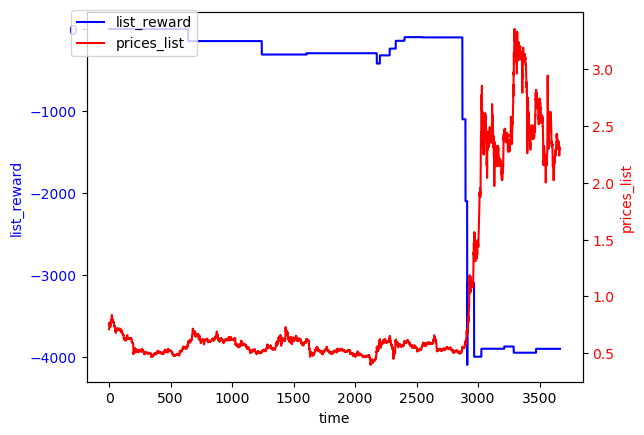

In [16]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(balances, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()

# Training XGBOOST

In [ ]:
# Training XGBoost
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y

if TRAINING:
    df_all = pd.read_csv("data_his/TIAUSDT_2024-08-16_2025-03-18_15m_fapiv1.csv")
    df = df_all.iloc[:20000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
    display(df.head(1))
    display(df.tail(2))
    rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3,time_pred=10, num_random=10000, seq=30)


    x, y = create_dataset(df_all, rs, 40)
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(x.shape[0], -1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)


    param = {
        'max_depth': 25,
        'eta': 0.1,
        'objective': 'multi:softmax',  # Multiclass classification
        'num_class': 3,                # Number of classes
        'eval_metric': 'merror'       # Multiclass classification error rate
    }
    watchlist = [(dtrain, 'train'), (dtest, 'eval')]

    # Train the model
    num_round = 50
    bst = xgb.train(param, dtrain, num_round, evals=watchlist, verbose_eval=False)

    # Make predictions
    y_pred_prob = bst.predict(dtest)
    y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)

    print("Precision per class:", precision)
    print("Recall per class:", recall)
    print("F1-score per class:", f1)

    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print("\nWeighted Precision:", precision_weighted)
    print("Weighted Recall:", recall_weighted)
    print("Weighted F1-score:", f1_weighted)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
    cmd.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()